# Tests

## Setup

In [25]:
import io
from math import acos, sin, cos, ceil
import time
import typing
import torch
import torchvision
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    import torch_radon
import radon

In [2]:
def shepp_logan_phantom(n: int) -> torch.Tensor:
    phantom = torch.zeros((n,n))
    centers = torch.tensor([[0, 0], [0, -0.0184], [0.11, 0], [-0.11, 0], [0, 0.175], [0, 0.05], [0, -0.05], [-0.04, -0.3025], [0, -0.3025], [0.03, -0.3025]])
    axes = torch.tensor([[0.69, 0.92], [0.6624, 0.874], [0.11, 0.31], [0.16, 0.41], [0.21, 0.25], [0.046, 0.046], [0.046, 0.046], [0.046, 0.023], [0.023, 0.023], [0.023, 0.046]])
    theta = torch.tensor([0, 0, -0.31415926535, 0.31415926535, 0, 0, 0, 0, 0, 0])
    intensity = torch.tensor([2, -1.0, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    x,y = torch.meshgrid(torch.linspace(-0.5, 0.5, n), -torch.linspace(-0.5, 0.5, n), indexing="ij")
    with torch.no_grad():
        for i in range(10):
            phantom[
                torch.square((x-centers[i,0])*cos(theta[i])+(y-centers[i,1])*sin(theta[i]))/((axes[i,0]/2.0)**2)+
                torch.square((x-centers[i,0])*sin(theta[i])-(y-centers[i,1])*cos(theta[i]))/((axes[i,1]/2.0)**2)
                <= 1.0] += intensity[i]
    return phantom.T/2.0

In [29]:
def slerp(low: float, high: float, val: torch.Tensor) -> torch.Tensor:
    return torch.sin((1.0-val)*acos(low*high))/sin(acos(low*high))*low+torch.sin(val*acos(low*high))/sin(acos(low*high))*high

## Large images

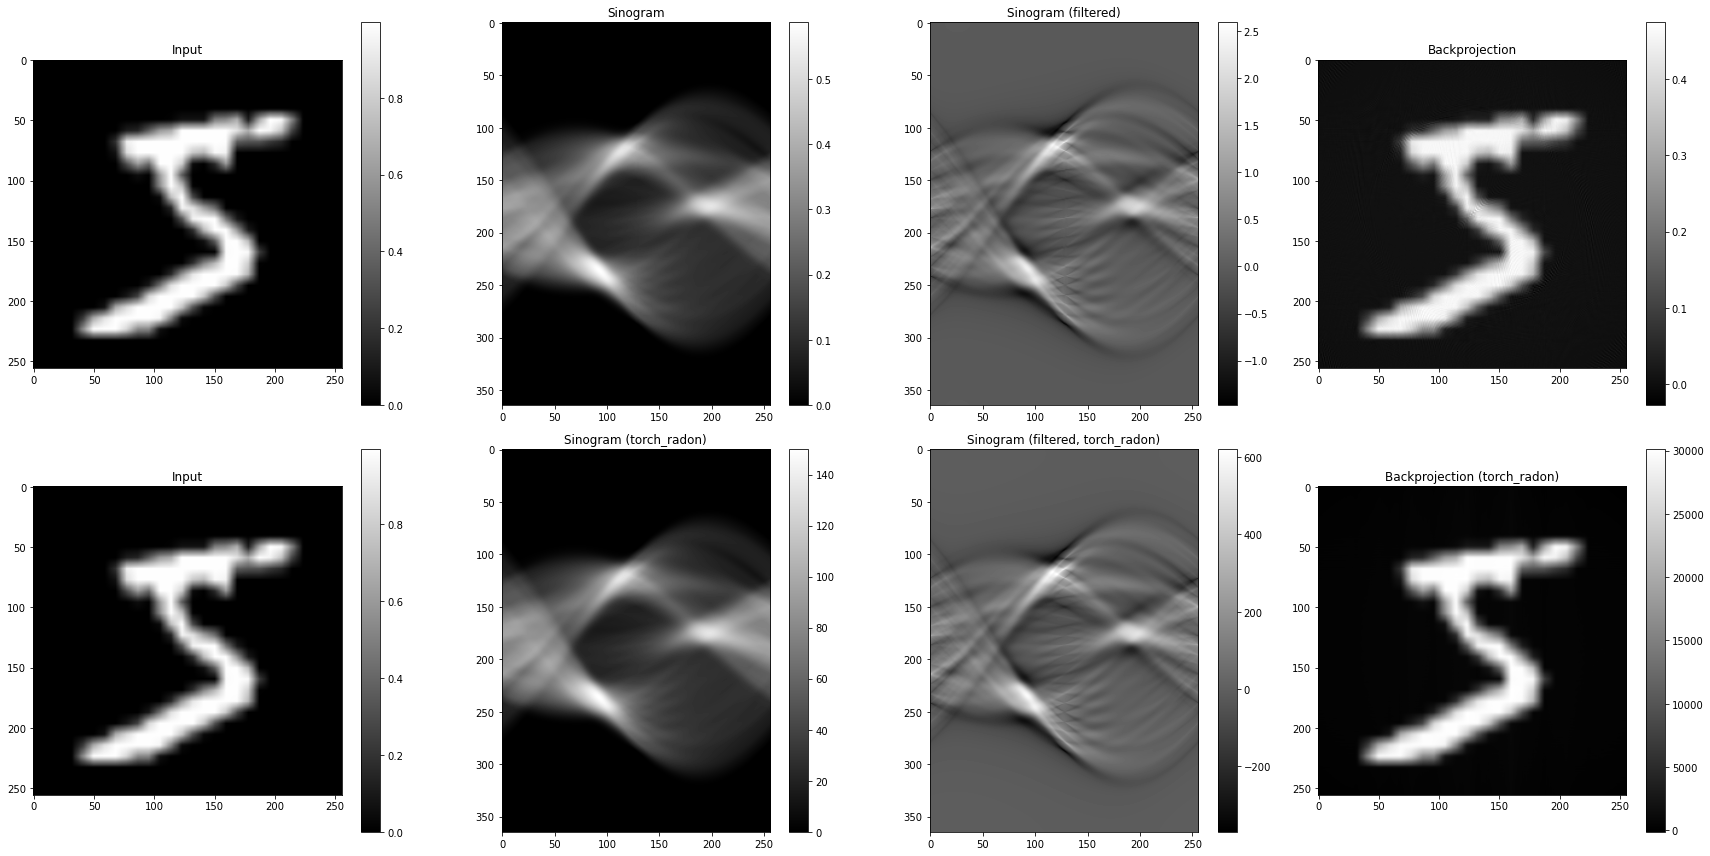

In [11]:
_img = next(iter(torchvision.datasets.MNIST("/data/datasets", True, torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((256,256))
]))))[0].unsqueeze(0)
plt.subplots(2, 4, figsize=(24,12))

plt.subplot(2, 4, 1)
plt.title("Input")
plt.imshow(_img[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
_sino = radon.radon_forward(_img)
plt.subplot(2, 4, 2)
plt.title("Sinogram")
plt.imshow(_sino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_fsino = radon.radon_filter(_sino, radon.ram_lak_filter, None)
plt.subplot(2, 4, 3)
plt.title("Sinogram (filtered)")
plt.imshow(_fsino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_recon = radon.radon_backward(_fsino, _img.shape[3])
plt.subplot(2, 4, 4)
plt.title("Backprojection")
plt.imshow(_recon[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()

plt.subplot(2, 4, 5)
plt.title("Input")
plt.imshow(_img[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
_torchradon = torch_radon.Radon(_img.shape[3], torch.linspace(0.0, torch.pi, 256), _sino.shape[3])
_sino = _torchradon.forward(_img.to("cuda")).to("cpu")
plt.subplot(2, 4, 6)
plt.title("Sinogram (torch_radon)")
plt.imshow(_sino.flip(2,3)[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_fsino = radon.radon_filter(_sino, radon.ram_lak_filter, None)
plt.subplot(2, 4, 7)
plt.title("Sinogram (filtered, torch_radon)")
plt.imshow(_fsino.flip(2,3)[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_recon = _torchradon.backward(_fsino.to("cuda")).to("cpu")
plt.subplot(2, 4, 8)
plt.title("Backprojection (torch_radon)")
plt.imshow(_recon[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()

plt.tight_layout()
plt.show()
%reset_selective -f \b_.*

## Small images

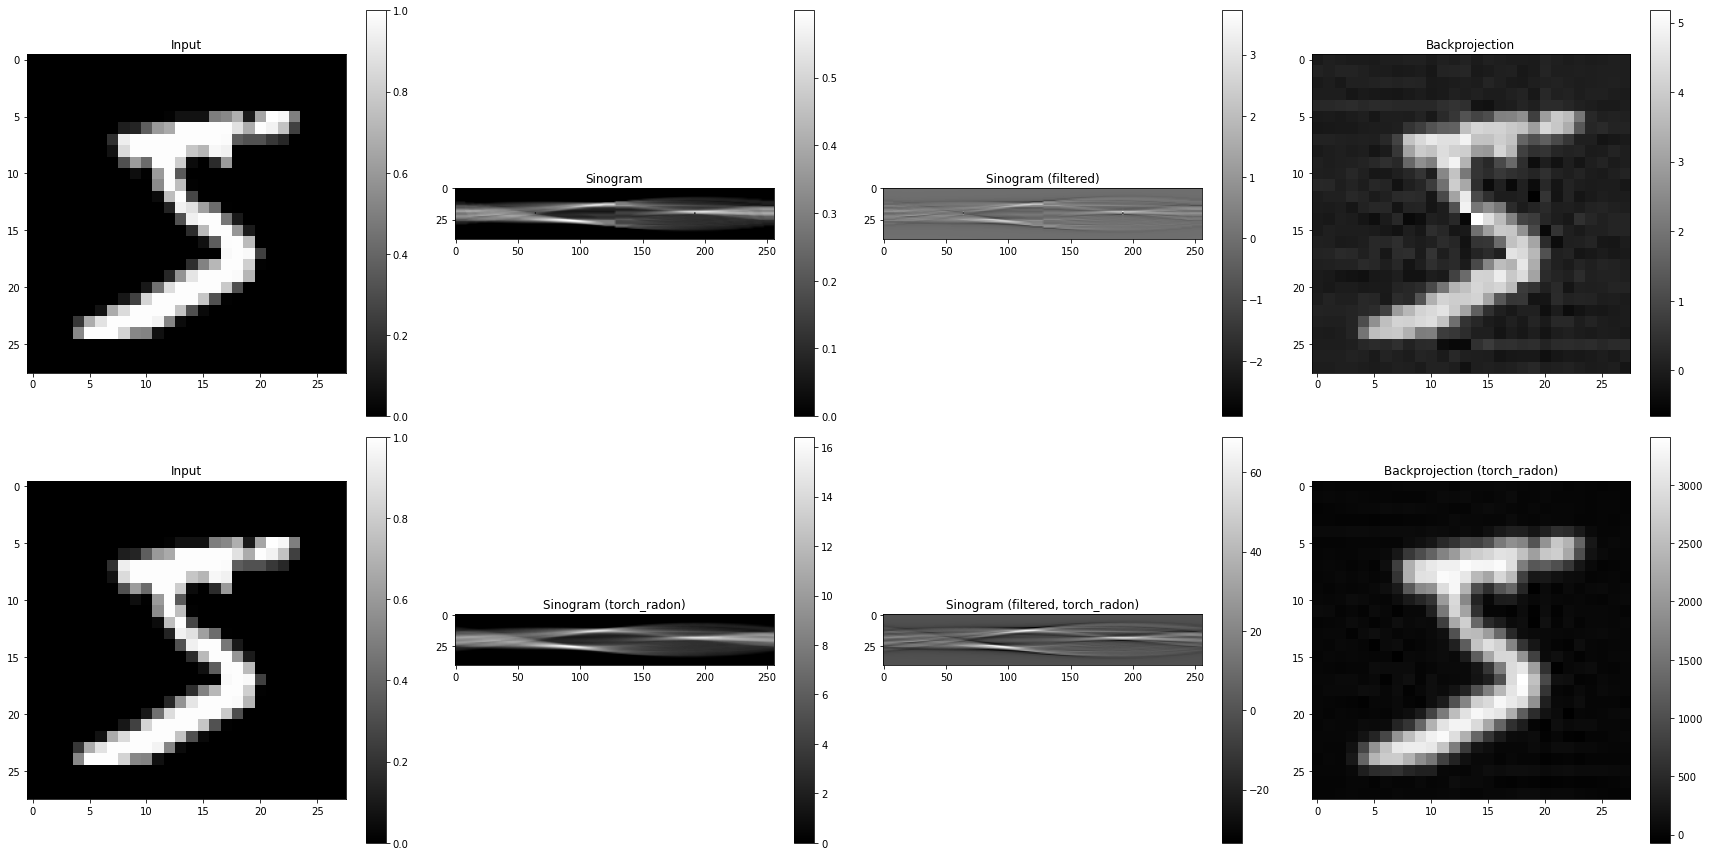

In [15]:
_img = next(iter(torchvision.datasets.MNIST("/data/datasets", True, torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
]))))[0].unsqueeze(0)
plt.subplots(2, 4, figsize=(24,12))

plt.subplot(2, 4, 1)
plt.title("Input")
plt.imshow(_img[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
_sino = radon.radon_forward(_img)
plt.subplot(2, 4, 2)
plt.title("Sinogram")
plt.imshow(_sino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_fsino = radon.radon_filter(_sino, radon.ram_lak_filter, None)
plt.subplot(2, 4, 3)
plt.title("Sinogram (filtered)")
plt.imshow(_fsino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_recon = radon.radon_backward(_fsino, _img.shape[3])
plt.subplot(2, 4, 4)
plt.title("Backprojection")
plt.imshow(_recon[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()

plt.subplot(2, 4, 5)
plt.title("Input")
plt.imshow(_img[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
_torchradon = torch_radon.Radon(_img.shape[3], torch.linspace(0.0, torch.pi, 256), _sino.shape[3])
_sino = _torchradon.forward(_img.to("cuda")).to("cpu")
plt.subplot(2, 4, 6)
plt.title("Sinogram (torch_radon)")
plt.imshow(_sino.flip(2,3)[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_fsino = radon.radon_filter(_sino, radon.ram_lak_filter, None)
plt.subplot(2, 4, 7)
plt.title("Sinogram (filtered, torch_radon)")
plt.imshow(_fsino.flip(2,3)[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_recon = _torchradon.backward(_fsino.to("cuda")).to("cpu")
plt.subplot(2, 4, 8)
plt.title("Backprojection (torch_radon)")
plt.imshow(_recon[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()

plt.tight_layout()
plt.show()
%reset_selective -f \b_.*

## Angle SLERP

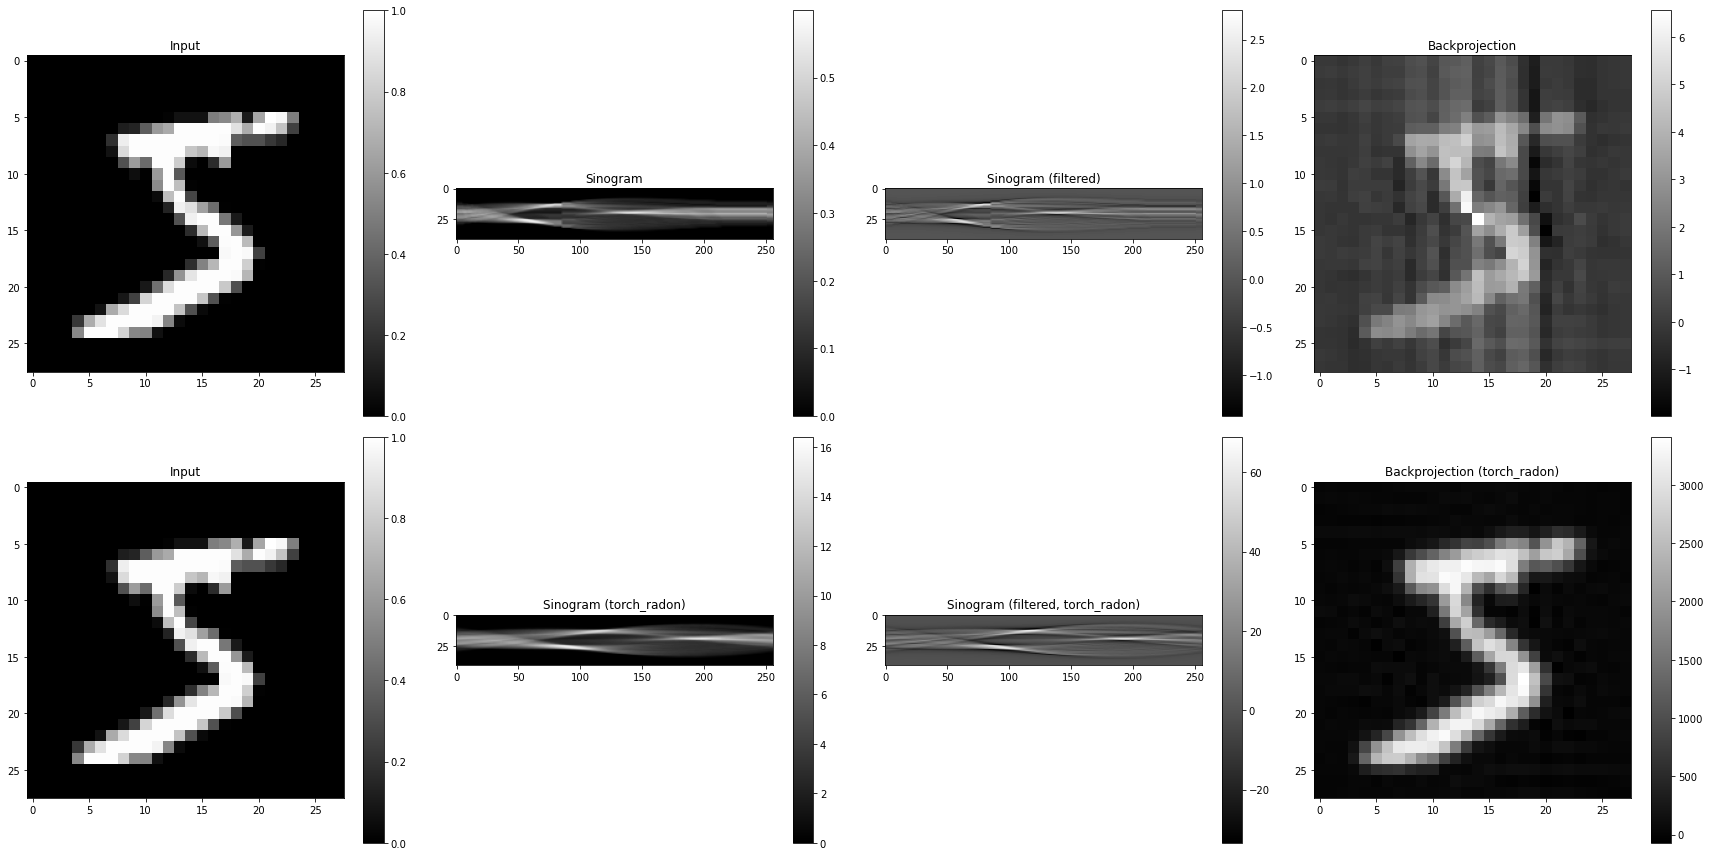

In [30]:
_img = next(iter(torchvision.datasets.MNIST("/data/datasets", True, torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
]))))[0].unsqueeze(0)
plt.subplots(2, 4, figsize=(24,12))

angles = slerp(0.0, torch.pi, torch.linspace(0.0, 1.0, 256)) #TODO
plt.subplot(2, 4, 1)
plt.title("Input")
plt.imshow(_img[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
_sino = radon.radon_forward(_img, angles)
plt.subplot(2, 4, 2)
plt.title("Sinogram")
plt.imshow(_sino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_fsino = radon.radon_filter(_sino, radon.ram_lak_filter, None)
plt.subplot(2, 4, 3)
plt.title("Sinogram (filtered)")
plt.imshow(_fsino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_recon = radon.radon_backward(_fsino, _img.shape[3], angles)
plt.subplot(2, 4, 4)
plt.title("Backprojection")
plt.imshow(_recon[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()

plt.subplot(2, 4, 5)
plt.title("Input")
plt.imshow(_img[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
_torchradon = torch_radon.Radon(_img.shape[3], torch.linspace(0.0, torch.pi, 256), _sino.shape[3])
_sino = _torchradon.forward(_img.to("cuda")).to("cpu")
plt.subplot(2, 4, 6)
plt.title("Sinogram (torch_radon)")
plt.imshow(_sino.flip(2,3)[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_fsino = radon.radon_filter(_sino, radon.ram_lak_filter, None)
plt.subplot(2, 4, 7)
plt.title("Sinogram (filtered, torch_radon)")
plt.imshow(_fsino.flip(2,3)[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_recon = _torchradon.backward(_fsino.to("cuda")).to("cpu")
plt.subplot(2, 4, 8)
plt.title("Backprojection (torch_radon)")
plt.imshow(_recon[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()

plt.tight_layout()
plt.show()
%reset_selective -f \b_.*

## Small images (radon) and large images + nearest (torchradon)

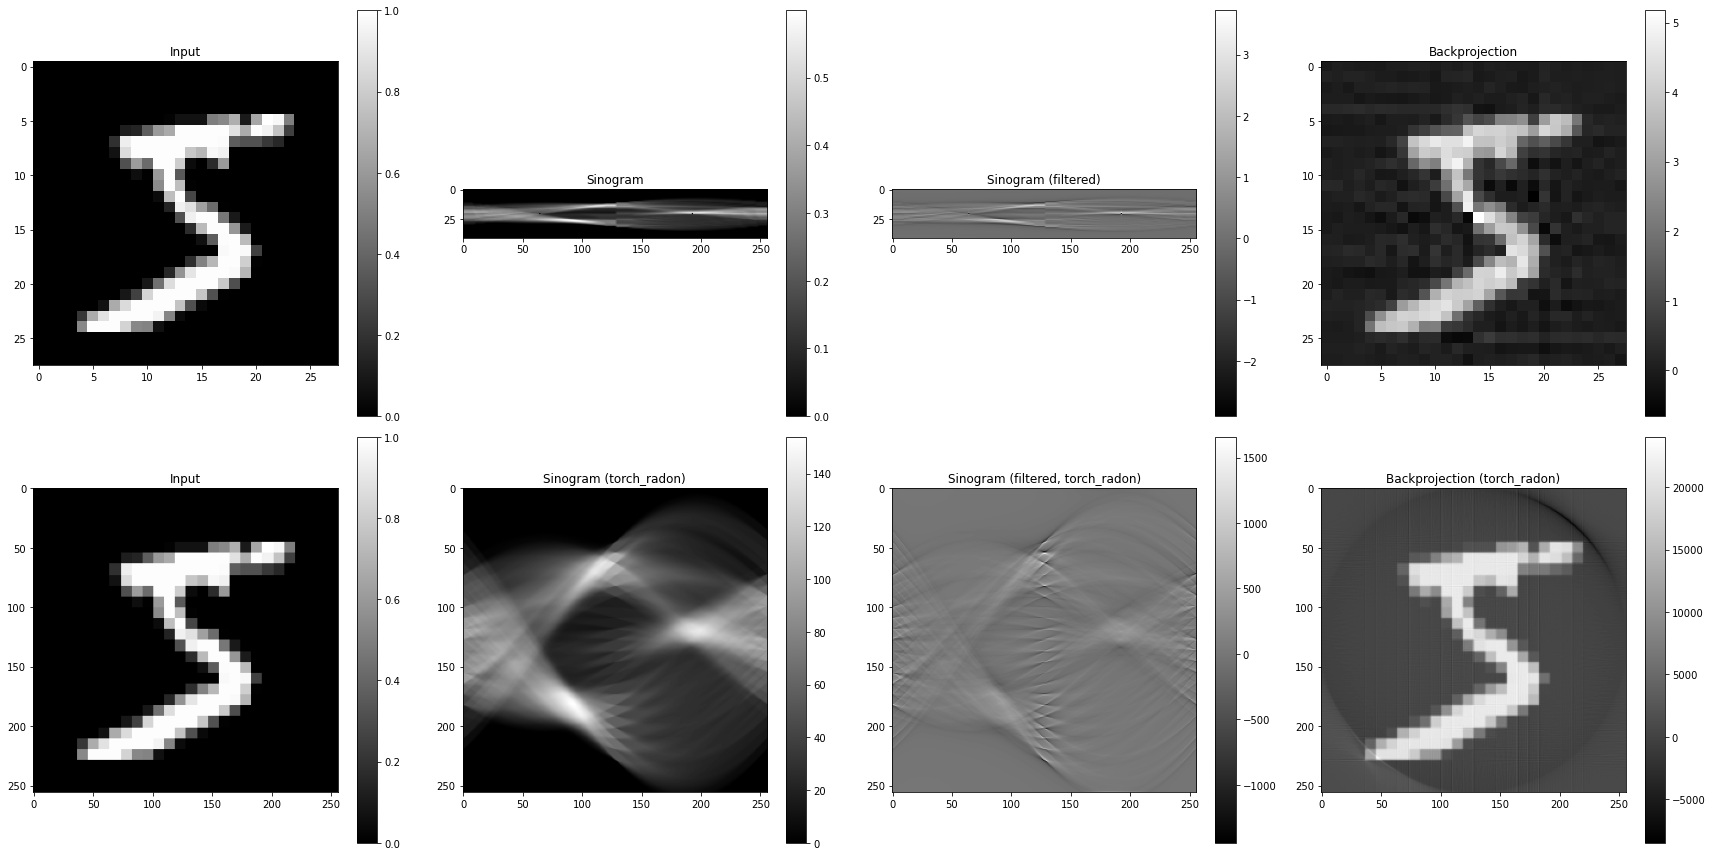

In [21]:
_imgA = next(iter(torchvision.datasets.MNIST("/data/datasets", True, torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
]))))[0].unsqueeze(0)
_imgB = next(iter(torchvision.datasets.MNIST("/data/datasets", True, torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((256,256), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
]))))[0].unsqueeze(0)
plt.subplots(2, 4, figsize=(24,12))

plt.subplot(2, 4, 1)
plt.title("Input")
plt.imshow(_imgA[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
_sino = radon.radon_forward(_imgA)
plt.subplot(2, 4, 2)
plt.title("Sinogram")
plt.imshow(_sino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_fsino = radon.radon_filter(_sino, radon.ram_lak_filter, None)
plt.subplot(2, 4, 3)
plt.title("Sinogram (filtered)")
plt.imshow(_fsino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_recon = radon.radon_backward(_fsino, _imgA.shape[3])
plt.subplot(2, 4, 4)
plt.title("Backprojection")
plt.imshow(_recon[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()

plt.subplot(2, 4, 5)
plt.title("Input")
plt.imshow(_imgB[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
_torchradon = torch_radon.Radon(_imgB.shape[3], torch.linspace(0.0, torch.pi, 256), _imgB.shape[3])
_sino = _torchradon.forward(_imgB.to("cuda")).to("cpu")
plt.subplot(2, 4, 6)
plt.title("Sinogram (torch_radon)")
plt.imshow(_sino.flip(2,3)[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_fsino = radon.radon_filter(_sino, radon.ram_lak_filter, None)
plt.subplot(2, 4, 7)
plt.title("Sinogram (filtered, torch_radon)")
plt.imshow(_fsino.flip(2,3)[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
_recon = _torchradon.backward(_fsino.to("cuda")).to("cpu")
plt.subplot(2, 4, 8)
plt.title("Backprojection (torch_radon)")
plt.imshow(_recon[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()

plt.tight_layout()
plt.show()
%reset_selective -f \b_.*

## C++ data exchange

### Write image

In [ ]:
img = next(iter(torchvision.datasets.MNIST("/data/datasets", True, torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))))[0].unsqueeze(0)
bytes = io.BytesIO()
torch.save(img, bytes)
with open("img.pt", "wb") as file:
    file.write(bytes.getbuffer())
%reset

### Read+Show sinogram

In [ ]:
with open("sino.pt", "rb") as file:
    sino = torch.load(file)[0,0].detach().to("cpu")
    plt.figure(figsize=(18,6))
    plt.imshow(sino.mT, cmap="gray")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
%reset